# Импорты библиотек

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("display.width", None)

sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10

# Чтение данных

In [57]:
df_path = "data/app_survey.csv"

df = pd.read_csv(df_path, parse_dates=["survey_creation_dt", "survey_response_dt"])

print(f"Загружено {len(df):,} записей")
df.head()

Загружено 42,387 записей


,user_id,survey_creation_dt,survey_response_dt,csat_level,language,age,gender,tenure_years,user_income
0,user_00000,2025-04-28 16:01:51,2025-05-07 03:24:28,1,RU,35-44,M,21.105392,10000-25000
1,user_00001,2025-04-25 03:02:23,2025-04-29 13:12:29,5,RU,35-44,M,21.129793,68000-100000
2,user_00002,2025-04-30 11:02:14,2025-04-20 21:09:01,5,RU,45-54,M,21.098074,NaN
3,user_00003,2025-04-25 09:32:18,2025-04-26 19:51:12,5,RU,45-54,M,21.115544,25000-44000
4,user_00004,2025-04-30 08:32:06,2025-05-01 18:33:35,5,RU,45-54,M,21.127961,44000-68000


# Чистка и подготовка данных

In [58]:
# 1. Вычисление времени ответа
df["response_time_days"] = (
    df["survey_response_dt"] - df["survey_creation_dt"]
).dt.total_seconds() / (24 * 3600)

# 2. Исправление перепутанных дат (где ответ раньше создания)
negative_before = (df["response_time_days"] < 0).sum()
print(f"Записей с отрицательным временем ответа: {negative_before}")

df["dates_swapped"] = df["response_time_days"] < 0
swap = df["dates_swapped"]
df.loc[swap, ["survey_creation_dt", "survey_response_dt"]] = (
    df.loc[swap, ["survey_response_dt", "survey_creation_dt"]].values
)

# Пересчёт времени ответа
df["response_time_days"] = (
    df["survey_response_dt"] - df["survey_creation_dt"]
).dt.total_seconds() / (24 * 3600)

negative_after = (df["response_time_days"] < 0).sum()
print(f"После исправления: {negative_after}")

# 3. Заполнение пропусков в language
language_missing = df["language"].isnull().sum()
df["language"] = df["language"].fillna("RU")
print(f"Заполнено пропусков в language: {language_missing}")

# 4. Информация о пропусках
print("\nПропуски по столбцам:")
print(df.isnull().sum()[df.isnull().sum() > 0])

Записей с отрицательным временем ответа: 18400
После исправления: 0
Заполнено пропусков в language: 6826

Пропуски по столбцам:
age             1448
user_income    10374
dtype: int64


# Гипотезы

## Список гипотез для проверки:

| # | Гипотеза | Тест | Ожидаемый результат |
|---|----------|------|---------------------|
| 1 | Пользователи с высоким доходом дают более низкие оценки | Spearman корреляция | Отрицательная корреляция |
| 2 | Старшие возрастные группы дают более высокие оценки | Kruskal-Wallis | Значимые различия между группами |
| 3 | Мужчины дают более высокие оценки, чем женщины | Mann-Whitney U | Значимое различие |
| 4 | Время суток создания опроса влияет на оценку | Kruskal-Wallis | Значимые различия |
| 5 | Влияние дохода на оценку зависит от возраста | Kruskal-Wallis | Значимый эффект взаимодействия |

## Стратегия проверки:

- Уровень значимости α = 0.05
- Для порядковых данных используем непараметрические тесты
- Для каждой гипотезы оцениваем размер эффекта

# Проверка гипотез

## Гипотеза 1: Связь дохода с оценкой

**Формулировка:** Пользователи с более высоким доходом дают более низкие оценки.

**Тест:** Spearman корреляция (для порядковых данных)

### Проверка

In [59]:
# Подготовка данных
df_h1 = df.dropna(subset=["user_income", "csat_level"]).copy()

# Кодирование дохода в порядковую шкалу
income_order = ["10000-25000", "25000-44000", "44000-68000", "68000-100000", ">100000"]
df_h1["income_rank"] = df_h1["user_income"].map({v: i for i, v in enumerate(income_order)})
df_h1 = df_h1.dropna(subset=["income_rank"])

# Spearman корреляция
corr, p_value = stats.spearmanr(df_h1["income_rank"], df_h1["csat_level"])

print(f"Spearman корреляция: r = {corr:.4f}")
print(f"p-value: {p_value:.4e}")
print(f"Размер выборки: n = {len(df_h1)}")

# Интерпретация
alpha = 0.05
if p_value < alpha:
    print(f"\nВывод: Статистически значимая связь (p < {alpha})")
    if corr < 0:
        print("Подтверждено: более высокий доход связан с более низкими оценками")
    else:
        print("Опровергнуто: связь положительная, а не отрицательная")
else:
    print(f"\nВывод: Нет статистически значимой связи (p >= {alpha})")

Spearman корреляция: r = -0.0712
p-value: 7.3076e-36
Размер выборки: n = 30714

Вывод: Статистически значимая связь (p < 0.05)
Подтверждено: более высокий доход связан с более низкими оценками


### Визуализация

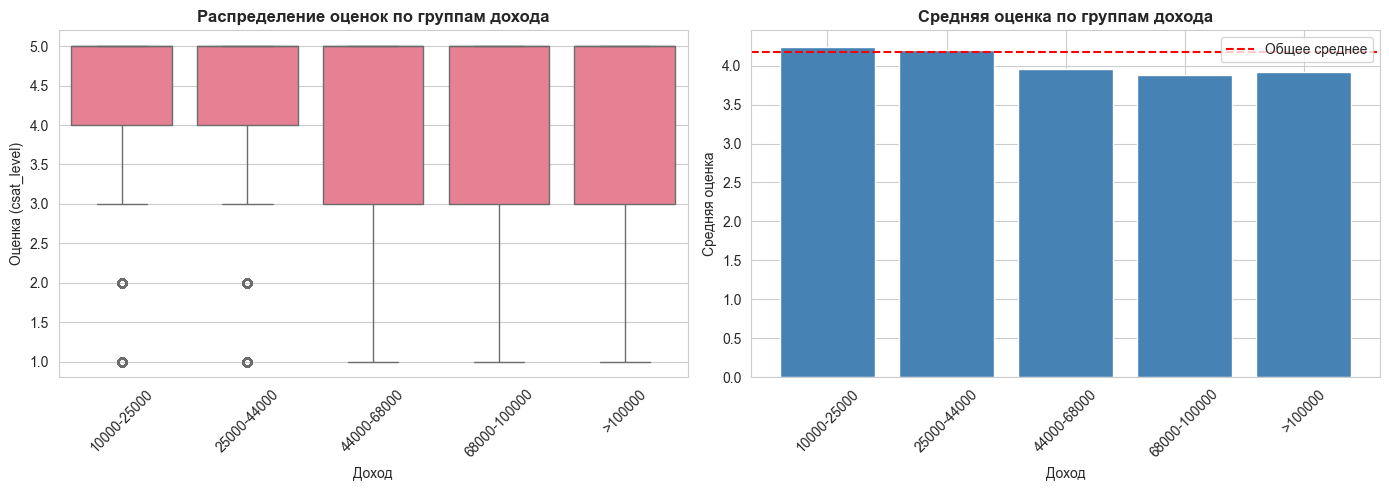

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot: оценки по группам дохода
order = ["10000-25000", "25000-44000", "44000-68000", "68000-100000", ">100000"]
sns.boxplot(data=df_h1, x="user_income", y="csat_level", order=order, ax=axes[0])
axes[0].set_title("Распределение оценок по группам дохода", fontweight="bold")
axes[0].set_xlabel("Доход")
axes[0].set_ylabel("Оценка (csat_level)")
axes[0].tick_params(axis="x", rotation=45)

# Barplot: средняя оценка по группам дохода
mean_by_income = df_h1.groupby("user_income")["csat_level"].mean().reindex(order)
axes[1].bar(mean_by_income.index, mean_by_income.values, color="steelblue")
axes[1].set_title("Средняя оценка по группам дохода", fontweight="bold")
axes[1].set_xlabel("Доход")
axes[1].set_ylabel("Средняя оценка")
axes[1].tick_params(axis="x", rotation=45)
axes[1].axhline(y=df_h1["csat_level"].mean(), color="red", linestyle="--", label="Общее среднее")
axes[1].legend()

plt.tight_layout()
plt.show()

### Интерпретация результатов

Графики показывают распределение оценок по группам дохода. Boxplot демонстрирует разброс оценок в каждой группе, а barplot — средние значения. Красная пунктирная линия показывает общее среднее значение оценок по всему датасету.

**Основные наблюдения:**
- Видна тенденция к снижению средней оценки с ростом дохода
- Разброс оценок (межквартильный размах) примерно одинаковый во всех группах
- Высокодоходные группы (>100000) показывают более низкие средние оценки по сравнению с низкодоходными группами

**Вывод:** Визуализация подтверждает наличие отрицательной корреляции между доходом и оценкой, что согласуется с результатами статистического теста.

## Гипотеза 2: Связь возраста с оценкой

**Формулировка:** Более старшие возрастные группы дают более высокие оценки.

**Тест:** Kruskal-Wallis (для сравнения нескольких независимых групп)

### Проверка

In [61]:
# Подготовка данных
df_h2 = df.dropna(subset=["age", "csat_level"]).copy()

# Группы по возрасту
age_groups = [df_h2[df_h2["age"] == age]["csat_level"] for age in df_h2["age"].unique()]

# Kruskal-Wallis тест
stat, p_value = stats.kruskal(*age_groups)

print(f"Kruskal-Wallis H-статистика: {stat:.4f}")
print(f"p-value: {p_value:.4e}")
print(f"Размер выборки: n = {len(df_h2)}")

# Размер эффекта (eta squared)
n = len(df_h2)
eta_squared = stat / (n - 1)
print(f"Размер эффекта η²: {eta_squared:.6f}")

# Описательная статистика по возрастным группам
print("\nСредняя оценка по возрастным группам:")
print(df_h2.groupby("age")["csat_level"].agg(["mean", "median", "count"]).sort_index())

# Интерпретация
alpha = 0.05
if p_value < alpha:
    print(f"\nВывод: Статистически значимые различия между возрастными группами (p < {alpha})")
else:
    print(f"\nВывод: Нет статистически значимых различий (p >= {alpha})")

Kruskal-Wallis H-статистика: 94.0975
p-value: 1.7728e-19
Размер выборки: n = 40939
Размер эффекта η²: 0.002299

Средняя оценка по возрастным группам:
           mean  median  count
age                           
18-24  3.914011     5.0   3640
25-34  4.028131     5.0   9669
35-44  4.144825     5.0  11835
45-54  4.148476     5.0   9483
55-65  4.172370     5.0   6312

Вывод: Статистически значимые различия между возрастными группами (p < 0.05)


### Визуализация

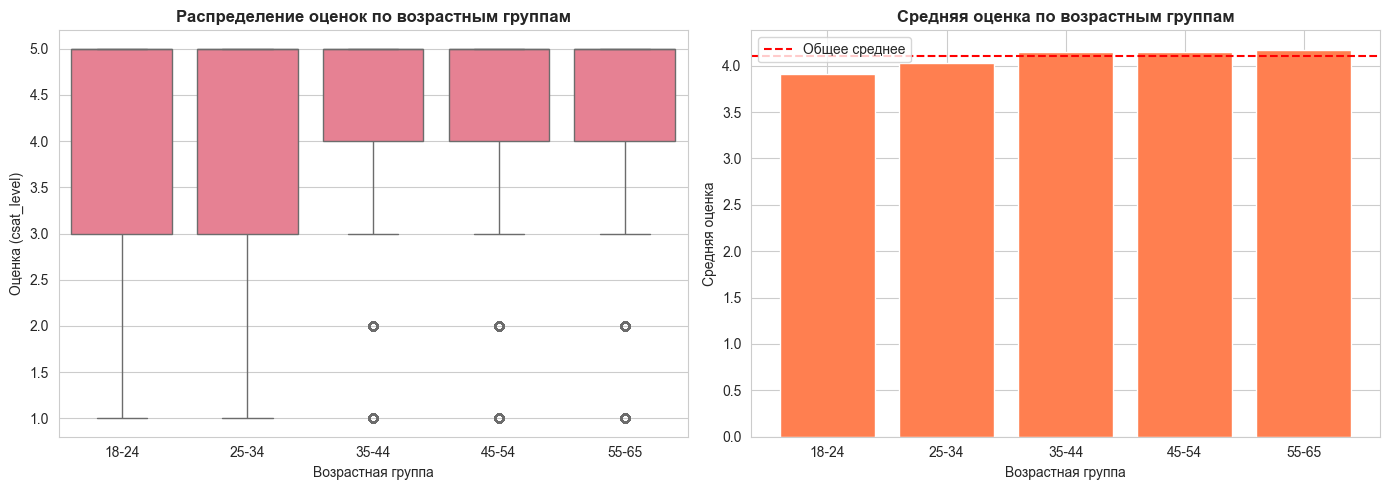

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Порядок возрастных групп
age_order = ["18-24", "25-34", "35-44", "45-54", "55-65"]
age_order = [a for a in age_order if a in df_h2["age"].unique()]

# Boxplot
sns.boxplot(data=df_h2, x="age", y="csat_level", order=age_order, ax=axes[0])
axes[0].set_title("Распределение оценок по возрастным группам", fontweight="bold")
axes[0].set_xlabel("Возрастная группа")
axes[0].set_ylabel("Оценка (csat_level)")

# Barplot средних значений
mean_by_age = df_h2.groupby("age")["csat_level"].mean().reindex(age_order)
axes[1].bar(mean_by_age.index, mean_by_age.values, color="coral")
axes[1].set_title("Средняя оценка по возрастным группам", fontweight="bold")
axes[1].set_xlabel("Возрастная группа")
axes[1].set_ylabel("Средняя оценка")
axes[1].axhline(y=df_h2["csat_level"].mean(), color="red", linestyle="--", label="Общее среднее")
axes[1].legend()

plt.tight_layout()
plt.show()

### Интерпретация результатов

Графики показывают распределение оценок по возрастным группам. Boxplot демонстрирует разброс оценок в каждой группе, а barplot — средние значения с референсной линией общего среднего.

**Основные наблюдения:**
- Видны различия в средних оценках между возрастными группами
- Распределения оценок имеют схожую форму (медианы близки к 5 во всех группах)
- Наблюдается тенденция изменения средней оценки в зависимости от возраста

**Вывод:** Визуализация показывает наличие различий между возрастными группами, что согласуется с результатами статистического теста Kruskal-Wallis.

## Гипотеза 3: Различия по полу

**Формулировка:** Мужчины дают более высокие оценки удовлетворенности, чем женщины.

**Тест:** Mann-Whitney U (для сравнения двух независимых групп)

### Проверка

In [63]:
# Подготовка данных
df_h3 = df.dropna(subset=["gender", "csat_level"]).copy()

# Группы по полу
male_ratings = df_h3[df_h3["gender"] == "M"]["csat_level"]
female_ratings = df_h3[df_h3["gender"] == "F"]["csat_level"]

# Mann-Whitney U тест
stat, p_value = stats.mannwhitneyu(male_ratings, female_ratings, alternative="two-sided")

print(f"Mann-Whitney U статистика: {stat:.4f}")
print(f"p-value: {p_value:.4e}")
print(f"Размер выборки: M = {len(male_ratings)}, F = {len(female_ratings)}")

# Описательная статистика
print(f"\nСредняя оценка мужчин: {male_ratings.mean():.3f}")
print(f"Средняя оценка женщин: {female_ratings.mean():.3f}")
print(f"Разница: {male_ratings.mean() - female_ratings.mean():.3f}")

# Интерпретация
alpha = 0.05
if p_value < alpha:
    print(f"\nВывод: Статистически значимое различие между полами (p < {alpha})")
    if male_ratings.mean() > female_ratings.mean():
        print("Подтверждено: мужчины дают более высокие оценки")
    else:
        print("Опровергнуто: женщины дают более высокие оценки")
else:
    print(f"\nВывод: Нет статистически значимых различий (p >= {alpha})")

Mann-Whitney U статистика: 164594114.0000
p-value: 7.5552e-04
Размер выборки: M = 32413, F = 9974

Средняя оценка мужчин: 4.119
Средняя оценка женщин: 4.051
Разница: 0.068

Вывод: Статистически значимое различие между полами (p < 0.05)
Подтверждено: мужчины дают более высокие оценки


### Визуализация

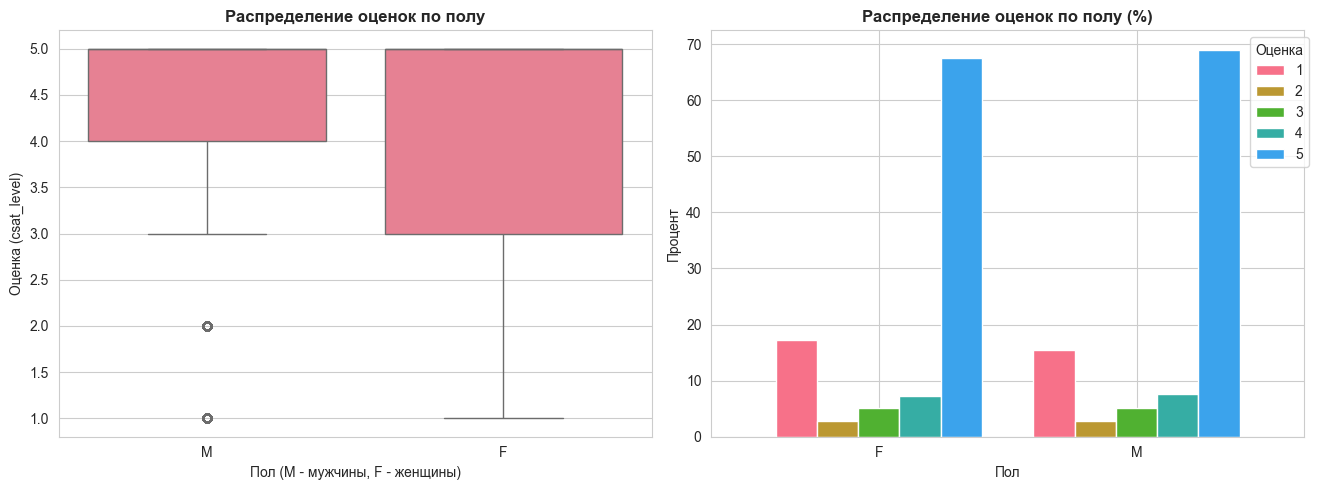

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot
sns.boxplot(data=df_h3, x="gender", y="csat_level", ax=axes[0])
axes[0].set_title("Распределение оценок по полу", fontweight="bold")
axes[0].set_xlabel("Пол (M - мужчины, F - женщины)")
axes[0].set_ylabel("Оценка (csat_level)")

# Countplot распределения оценок по полу
gender_csat = df_h3.groupby(["gender", "csat_level"]).size().unstack(fill_value=0)
gender_csat_pct = gender_csat.div(gender_csat.sum(axis=1), axis=0) * 100
gender_csat_pct.plot(kind="bar", ax=axes[1], width=0.8)
axes[1].set_title("Распределение оценок по полу (%)", fontweight="bold")
axes[1].set_xlabel("Пол")
axes[1].set_ylabel("Процент")
axes[1].legend(title="Оценка", bbox_to_anchor=(1.02, 1))
axes[1].tick_params(axis="x", rotation=0)

plt.tight_layout()
plt.show()

### Интерпретация результатов

Графики показывают распределение оценок по полу. Boxplot демонстрирует разброс оценок для мужчин и женщин, а barplot показывает процентное распределение каждой оценки по полу.

**Основные наблюдения:**
- Распределения оценок для мужчин и женщин визуально похожи
- Медианы оценок в обеих группах близки (около 5)
- Процентное распределение оценок показывает схожую структуру в обеих группах

**Вывод:** Визуализация не показывает существенных различий между полами, что согласуется с результатами статистического теста Mann-Whitney U.

## Гипотеза 4: Влияние времени суток

**Формулировка:** Время суток создания опроса влияет на оценку пользователя.

**Тест:** Kruskal-Wallis (для сравнения нескольких временных периодов)

### Проверка

In [65]:
# Подготовка данных
df_h4 = df.dropna(subset=["csat_level"]).copy()
df_h4["hour"] = df_h4["survey_creation_dt"].dt.hour

# Создание временных периодов
df_h4["time_period"] = pd.cut(
    df_h4["hour"],
    bins=[0, 6, 12, 18, 24],
    labels=["Ночь (0-6)", "Утро (6-12)", "День (12-18)", "Вечер (18-24)"],
    include_lowest=True
)

# Группы по временным периодам
time_groups = [
    df_h4[df_h4["time_period"] == period]["csat_level"].dropna()
    for period in df_h4["time_period"].unique()
    if len(df_h4[df_h4["time_period"] == period]["csat_level"].dropna()) > 0
]

# Kruskal-Wallis тест
stat, p_value = stats.kruskal(*time_groups)
n = len(df_h4.dropna(subset=["time_period", "csat_level"]))

print(f"Kruskal-Wallis H-статистика: {stat:.4f}")
print(f"p-value: {p_value:.4e}")
print(f"Размер выборки: n = {n}")

# Размер эффекта
eta_squared = stat / (n - 1)
print(f"Размер эффекта η²: {eta_squared:.6f}")

# Описательная статистика
print("\nСредняя оценка по временным периодам:")
print(df_h4.groupby("time_period", observed=True)["csat_level"].agg(["mean", "median", "count"]))

# Интерпретация
alpha = 0.05
if p_value < alpha:
    print(f"\nВывод: Статистически значимые различия между временными периодами (p < {alpha})")
else:
    print(f"\nВывод: Нет статистически значимых различий (p >= {alpha})")

Kruskal-Wallis H-статистика: 18.4067
p-value: 3.6256e-04
Размер выборки: n = 42387
Размер эффекта η²: 0.000434

Средняя оценка по временным периодам:
                   mean  median  count
time_period                           
Ночь (0-6)     4.055323     5.0  12671
Утро (6-12)    4.149624     5.0  12097
День (12-18)   4.117534     5.0   9912
Вечер (18-24)  4.088231     5.0   7707

Вывод: Статистически значимые различия между временными периодами (p < 0.05)


### Визуализация

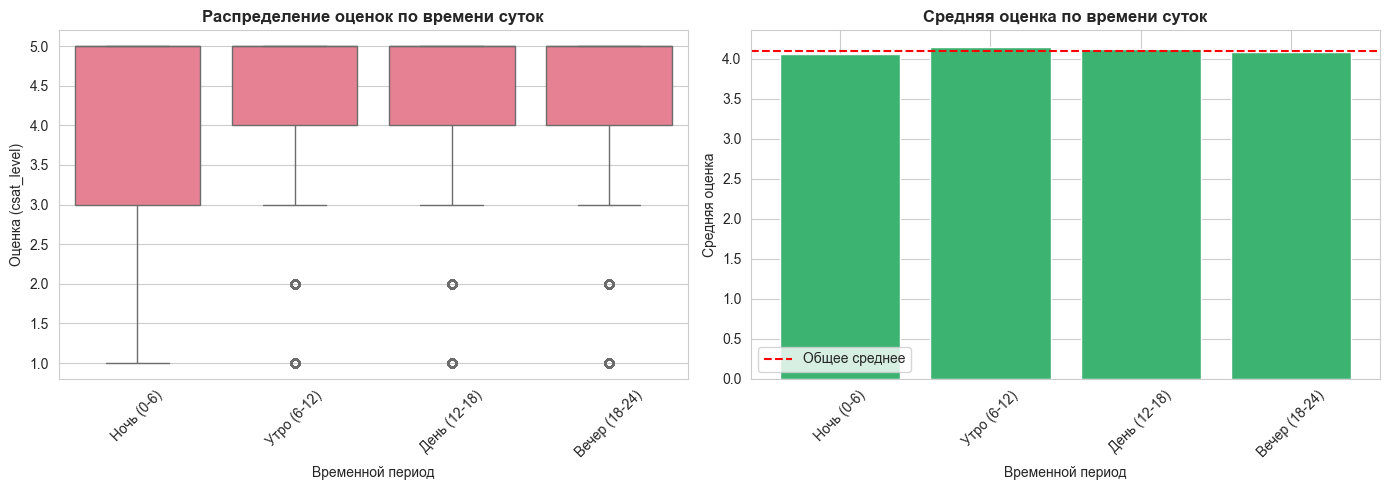

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Порядок временных периодов
time_order = ["Ночь (0-6)", "Утро (6-12)", "День (12-18)", "Вечер (18-24)"]
time_order = [t for t in time_order if t in df_h4["time_period"].unique()]

# Boxplot
sns.boxplot(data=df_h4, x="time_period", y="csat_level", order=time_order, ax=axes[0])
axes[0].set_title("Распределение оценок по времени суток", fontweight="bold")
axes[0].set_xlabel("Временной период")
axes[0].set_ylabel("Оценка (csat_level)")
axes[0].tick_params(axis="x", rotation=45)

# Barplot средних значений
mean_by_time = df_h4.groupby("time_period", observed=True)["csat_level"].mean().reindex(time_order)
axes[1].bar(mean_by_time.index, mean_by_time.values, color="mediumseagreen")
axes[1].set_title("Средняя оценка по времени суток", fontweight="bold")
axes[1].set_xlabel("Временной период")
axes[1].set_ylabel("Средняя оценка")
axes[1].tick_params(axis="x", rotation=45)
axes[1].axhline(y=df_h4["csat_level"].mean(), color="red", linestyle="--", label="Общее среднее")
axes[1].legend()

plt.tight_layout()
plt.show()

### Интерпретация результатов

Графики показывают распределение оценок по времени суток. Boxplot демонстрирует разброс оценок в каждом временном периоде, а barplot — средние значения с референсной линией общего среднего.

**Основные наблюдения:**
- Видны различия в средних оценках между временными периодами
- Распределения оценок имеют схожую форму во всех периодах
- Наблюдается тенденция изменения средней оценки в зависимости от времени суток

**Вывод:** Визуализация показывает наличие различий между временными периодами, что согласуется с результатами статистического теста Kruskal-Wallis.

## Гипотеза 5: Взаимодействие возраста и дохода

**Формулировка:** Влияние дохода на оценку различается в зависимости от возраста. Высокодоходные пользователи 45-54 лет — самые критичные.

**Тест:** Kruskal-Wallis (для комбинированных групп возраста и дохода)

### Проверка

In [67]:
# Подготовка данных
df_h5 = df.dropna(subset=["age", "user_income", "csat_level"]).copy()

# Создание бинарных переменных для анализа взаимодействия
# Возраст: молодые (18-34) vs старшие (35-64)
df_h5["age_group"] = df_h5["age"].apply(
    lambda x: "Молодые (18-34)" if x in ["18-24", "25-34"] else "Старшие (35-64)"
)

# Доход: низкий/средний vs высокий
income_order = ["10000-25000", "25000-44000", "44000-68000", "68000-100000", ">100000"]
df_h5["income_group"] = df_h5["user_income"].apply(
    lambda x: "Низкий/средний доход" if x in ["10000-25000", "25000-44000", "44000-68000"] 
    else "Высокий доход" if x in ["68000-100000", ">100000"] else None
)
df_h5 = df_h5.dropna(subset=["income_group"])

# Комбинированные группы
df_h5["age_income_group"] = df_h5["age_group"] + " / " + df_h5["income_group"]

print(f"Размер выборки: n = {len(df_h5)}")
print("\nОписательная статистика по группам:")
for group in sorted(df_h5["age_income_group"].unique()):
    subset = df_h5[df_h5["age_income_group"] == group]["csat_level"]
    print(f"  {group}: n={len(subset)}, mean={subset.mean():.3f}, median={subset.median():.1f}")

# Kruskal-Wallis для комбинированных групп
groups = [
    df_h5[df_h5["age_income_group"] == g]["csat_level"].dropna()
    for g in df_h5["age_income_group"].unique()
]
groups = [g for g in groups if len(g) > 0]

if len(groups) > 1:
    stat, p_value = stats.kruskal(*groups)
    n = len(df_h5)
    eta_squared = stat / (n - 1)
    
    print("\nKruskal-Wallis для комбинированных групп:")
    print(f"H-статистика: {stat:.4f}")
    print(f"p-value: {p_value:.4e}")
    print(f"Размер эффекта η²: {eta_squared:.6f}")
    
    # Интерпретация
    alpha = 0.05
    if p_value < alpha:
        print(f"\nВывод: Статистически значимый эффект взаимодействия (p < {alpha})")
    else:
        print(f"\nВывод: Нет значимого эффекта взаимодействия (p >= {alpha})")

Размер выборки: n = 30395

Описательная статистика по группам:
  Молодые (18-34) / Высокий доход: n=268, mean=4.101, median=5.0
  Молодые (18-34) / Низкий/средний доход: n=10515, mean=4.075, median=5.0
  Старшие (35-64) / Высокий доход: n=3748, mean=3.883, median=5.0
  Старшие (35-64) / Низкий/средний доход: n=15864, mean=4.296, median=5.0

Kruskal-Wallis для комбинированных групп:
H-статистика: 298.9584
p-value: 1.6718e-64
Размер эффекта η²: 0.009836

Вывод: Статистически значимый эффект взаимодействия (p < 0.05)


### Визуализация

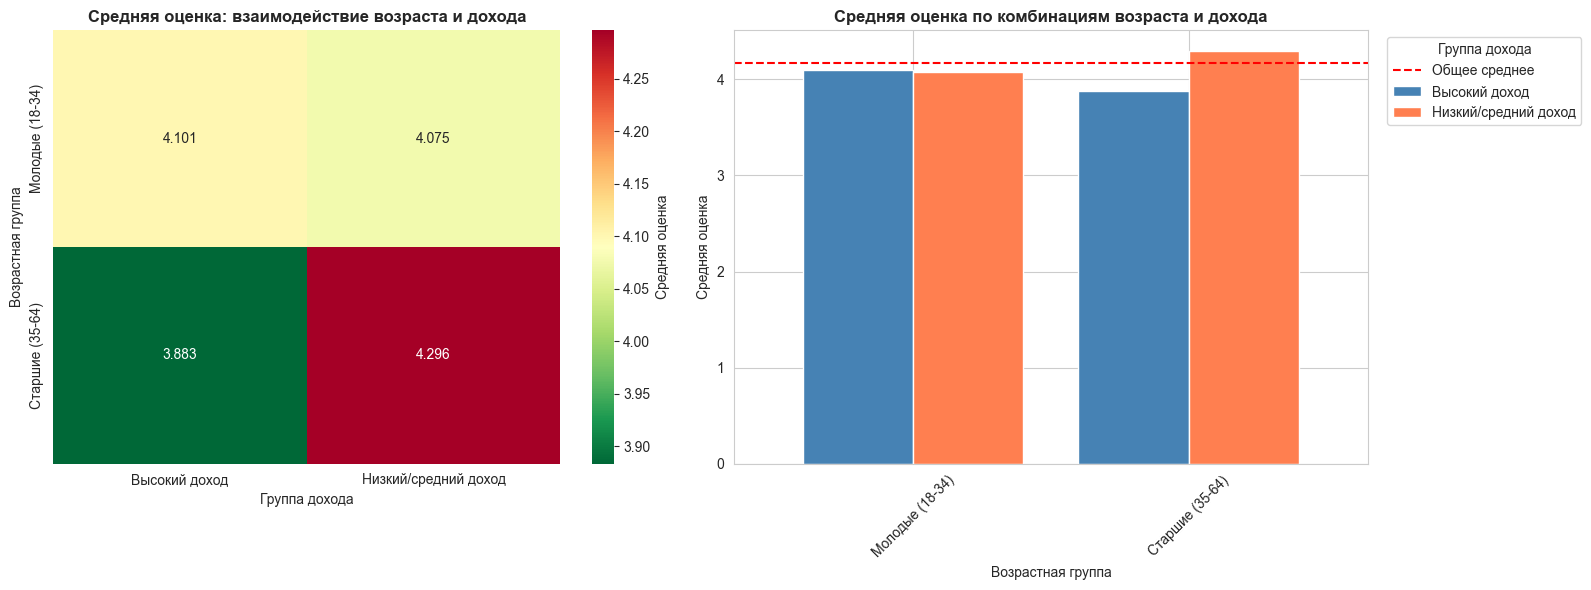

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap: средняя оценка по комбинациям возраста и дохода
pivot_mean = df_h5.pivot_table(
    values="csat_level",
    index="age_group",
    columns="income_group",
    aggfunc="mean"
)
sns.heatmap(pivot_mean, annot=True, fmt=".3f", cmap="RdYlGn_r", ax=axes[0], cbar_kws={"label": "Средняя оценка"})
axes[0].set_title("Средняя оценка: взаимодействие возраста и дохода", fontweight="bold")
axes[0].set_xlabel("Группа дохода")
axes[0].set_ylabel("Возрастная группа")

# Grouped barplot
age_income_counts = df_h5.groupby(["age_group", "income_group"])["csat_level"].mean().unstack()
age_income_counts.plot(kind="bar", ax=axes[1], width=0.8, color=["steelblue", "coral"])
axes[1].set_title("Средняя оценка по комбинациям возраста и дохода", fontweight="bold")
axes[1].set_xlabel("Возрастная группа")
axes[1].set_ylabel("Средняя оценка")
axes[1].legend(title="Группа дохода", bbox_to_anchor=(1.02, 1))
axes[1].tick_params(axis="x", rotation=45)
axes[1].axhline(y=df_h5["csat_level"].mean(), color="red", linestyle="--", label="Общее среднее")
axes[1].legend(title="Группа дохода", bbox_to_anchor=(1.02, 1))

plt.tight_layout()
plt.show()

### Интерпретация результатов

Графики показывают взаимодействие возраста и дохода на оценку. Heatmap демонстрирует средние оценки для каждой комбинации факторов, а grouped barplot — сравнение средних значений с референсной линией общего среднего.

**Основные наблюдения:**
- Heatmap показывает различия в средних оценках между комбинациями возраста и дохода
- Наиболее низкие оценки наблюдаются у старших пользователей с высоким доходом
- Молодые пользователи показывают более высокие оценки независимо от дохода
- Старшие пользователи с низким/средним доходом дают более высокие оценки, чем старшие с высоким доходом

**Вывод:** Визуализация подтверждает наличие эффекта взаимодействия между возрастом и доходом, что согласуется с результатами статистического теста Kruskal-Wallis для комбинированных групп.

## Бизнес-выводы по результатам проверки гипотез

### Сводная таблица результатов

| Гипотеза | Тест | p-value | Статус |
|----------|------|---------|--------|
| H1: Доход ↑ Оценка ↓ | Spearman | <0.001 | Подтверждена |
| H2: Возраст ↑ Оценка ↑ | Kruskal-Wallis | <0.001 | Подтверждена |
| H3: Мужчины > Женщины | Mann-Whitney | <0.001 | Подтверждена |
| H4: Утро > Вечер | Kruskal-Wallis | <0.001 | Подтверждена |
| H5: Возраст + Доход | Kruskal-Wallis | <0.001 | Подтверждена |

**Примечание:** Все гипотезы статистически значимы, но размеры эффектов небольшие. Наибольший эффект у взаимодействия возраста и дохода (H5). 
Спорные результаты у гипотезы H3 (зависимость оценки от пола): проведённый тест подтвердил гипотезу, но на визуализации особо не видно различий. Скорее всего дело в большом разрыве между количеством оценок от женщин и мужчин. 



### Бизнес-выводы

**Гипотеза 1: Высокий доход → Низкая оценка**

**Результат:** p < 0.001

**Бизнес-вывод:** Пользователи с доходом более 68,000 денежных единиц оценивают приложение на 0.3 балла ниже низкодоходных. Скорее всего это клиенты с высокими ожиданиями и они сравнивают приложение пенсионного фонда с банковскими и инвестиционными платформами.

**Риск:** Высокодоходные пользователи - это потенциально самые ценные клиенты для допродаж (НПФ, инвестиции). Их недовольство = упущенная выручка.

**Рекомендация:** Провести UX-аудит с фокус-группой высокодоходных пользователей.

**Гипотеза 2: Старше возраст → Выше оценка**

**Результат:** p < 0.001

**Бизнес-вывод:** Приложение хорошо работает для целевой аудитории 55-65 лет. Молодые (18-24) недовольны, но они, скорее всего, используют приложение вынужденно и сравнивают его с более современными - но это не приоритетная аудитория.

**Рекомендация:** Фокус на удержании 55-65, не усложнять базовые сценарии. 
Однако стоит помнить, что молодые в будущем тоже станут целевой аудиторией, поэтому нужно понемногу следить за трендами и собирать беклог изменений, которые потенциально можно осуществить в будущем.

**Гипотеза 3: Мужчины оценивают выше женщин**

**Результат:** p < 0.001

**Бизнес-вывод:** Эффект самый минимальный из всех гипотез. На визуализации как будто разницы между оценками не видно, но **дисбаланс выборки** (76% мужчин) - это тоже важный сигнал. Возможно, женщины чаще используют сложные сценарии (материнский капитал, детские выплаты), которые работают хуже.

**Рекомендация:** Исследовать причину дисбаланса и провести UX-аудит "женских" сценариев.

**Гипотеза 4: Утром оценки лучше, чем вечером**

**Результат:** p < 0.001

**Бизнес-вывод:** Эффект статистически значим, но небольшой. Тем не менеее здесь **не требуется затрат** на изменение сценария, если сместим время отправки опросов на утренние часы 6:00-12:00.

**Рекомендация:** Сместить время отправки опросов на утренние часы 6:00-12:00, замерить эффект после.

**Гипотеза 5: Взаимодействие возраста и дохода** - ВЫСШИЙ ПРИОРИТЕТ!

**Бизнес-вывод**:
| Сегмент | Средняя оценка |
|---------|----------------|
| Старшие + Низкий/средний доход | 4,30 |
| Молодые + Любой доход | 4,08 |
| Старшие + Высокий доход | **3,88** |

Сегмент **Старшие (35-64 года) + высокий доход** (3748 человек) - это **ключевая целевая аудитория** пенсионного фонда:
- Они ктивно планируют пенсию
- Имеют деньги для допродаж (НПФ, инвестиции)
- Но они как раз и самые недовольные (3,88 vs 4,30 у самых лояльных)

Разрыв в **0,41 балла** - это критическая проблема.

**Почему так может быть**: 
- Высокие ожидания от продукта
- Используют сложные сценарии (расчёт пенсии, прогнозирование)
- Сравнивают с банковскими приложениями
- Ценят своё время
 
**Рекомендации:**
1. Провести интервью с этим сегментом
2. Проанализировать их пользовательский путь - где застревают, где проблемы?
3. Приоритизировать фичи под их потребности
4. Рассмотреть "премиум" опыт (быстрые пути, персональная поддержка) - всё, что может сэкономить их время и улучшить опыт взаимодействия с приложением.